In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [10]:
# _____________________________________________________________________________________________________________________________________
# Function 1 - Reading datasets

def read_data(my_assets, start_date, end_date):
    data = yf.download(my_assets, interval = '1d', start = start_date, end = end_date)
    ohlc = ['Open', 'High', 'Low', 'Adj Close']
    for i in ohlc:
        data[i] = data[i].round(2)
    data = data.drop(columns=['Close', 'Volume'])
    return data

read_data(my_assets='MSFT', start_date='2018-01-01', end_date='2022-01-01')

# _____________________________________________________________________________________________________________________________________
# Function 2 - Calculate Relative Strength

def calculate_relative_strength(data, time_period):

    # set date as index
    data = data.set_index(data['Date'])

    col_to_use = 'Adj Close'
    # delta
    delta = data[col_to_use].diff(1)

    # gains and loss variables
    long = delta.copy()
    short = delta.copy()

    # conditions for delta (up or down)
    long[long < 0] = 0
    short[short > 0] = 0

    # average gains
    avg_gains = long.rolling(window = time_period).mean()

    # averages losses
    avg_losses = short.rolling(window = time_period).mean()

    return(avg_gains, avg_losses)

# ___________________________________________________________________________________________________________________________________________
# Function 3 - Calculate RSI

def calculate_RSI(avg_gains, avg_losses):
    # relative strength
    relative_strength = avg_gains / avg_losses

    # apply RSI formula 
    rsi = 100 - (100 / (1 + relative_strength))

    return rsi

# ___________________________________________________________________________________________________________________________________________
# Function 4 - Plot RSI
def plot_RSI(rsi, my_assets):

    # plot size
    plt.figure(figsize=(30,7.5))

    # plot rsi values against dates
    rsi_plot = sns.lineplot(x=data.index, y=rsi.values)
    rsi_plot.set_title(f'Relative Strength Index of {my_assets} stock')
    rsi_plot.set_ylabel('RSI Value')

    #plot all levels in RSI
    rsi_plot.axhline(30, color = 'green')
    rsi_plot.axhline(70, color = 'green')
    rsi_plot.axhline(20, color = 'yellow')
    rsi_plot.axhline(80, color = 'yellow')
    rsi_plot.axhline(10, color = 'red')
    rsi_plot.axhline(90, color = 'red')

    rsi_plot.legend()
    rsi.plot.show()

    col_to_use = 'Adj Close'
    # data = data[col_to_use]

    '''
    Below is the intuition for which the RSI Overbought and Oversold levels are formed
    '''

    # if RSI > 70, Overbought, indicate 'Short'
    if data.values > 70:

        for x,y in zip(data.index, data.values):

            label = 'Short'

            rsi_plot.annotate(label, 
                            (x,y), 
                            textcoords = 'offset points',  
                            xytext = (0,10), 
                            ha = 'center', 
                            fontsize = 25) # annotations on rsi_plot

            rsi_plot.scatter(data.index, data.values, label='Short', marker='v', ms=10, color='red', alpha=1, s=100) # plot scatter on rsi_plot

    # if RSI < 30, Oversold, indicate 'Long'
    if data.values < 30:

        for x,y in zip(data.index, data.values):
            
            label = 'Long'

            rsi_plot.annotate(label,
                            (x,y),
                            textcoords = 'offset points',
                            xytext = (0,10), 
                            ha = 'center',
                            fontsize = 25) # annotations on rsi_plot

            rsi_plot.scatter(data.index, data.values, label='Long', marker='^', ms=10, color='green', alpha=1, s=100) # plot scatter on rsi_plot

# ___________________________________________________________________________________________________________________________________________
# Function 5 - Combine all smaller elements to a single giant function

def Relative_Strength_Index(data, my_assets, time_period):

    avg_gains, avg_losses = calculate_relative_strength(data, time_period)
    rsi = calculate_RSI(avg_gains, avg_losses)
    plot_RSI(rsi, my_assets)

# ___________________________________________________________________________________________________________________________________________
# Function 6 - Producing a Bollinger Band for a particular asset

def Bollinger_Band(data, period, my_assets):
    col_to_use = 'Adj Close'
    plt.figure(figsize=(15,8))
    data['middle_band'] = data[col_to_use].rolling(period).mean() # essentially the moving average for the chosen time period

    data['upper_band'] = data[col_to_use].rolling(period).mean() + 2*(data[col_to_use].rolling(period).std())
    data['lower_band'] = data[col_to_use].rolling(period).mean() - 2*(data[col_to_use].rolling(period).std())


    '''
    generation of signals to determine upper and lower band crossovers
    '''

    long = []
    short = []

    for i in range(len(data[col_to_use])):

            # case 1: mA crosses ABOVE the upper band, indicate SELL signal
        if data[col_to_use][i] > data['upper_band'][i]: # OVERBOUGHT = SELL
            long.append(np.nan)
            short.append(data[col_to_use][i])

            #  case 2: mA crosses BELOW the lower band, indicate BUY signal
        elif data[col_to_use][i] < data['lower_band'][i]: #OVERSOLD = BUY
            long.append(data[col_to_use][i])
            short.append(np.nan)

        else:
            long.append(np.nan)
            short.append(np.nan)

    # plot results
    plt.figure(figsize=(15,10))

    bb_plot = sns.lineplot(data=data, x='Date', y=col_to_use)
    sns.lineplot(data = data, x = 'Date', y = 'upper_band')
    sns.lineplot(data = data, x = 'Date', y = 'middle_band')
    sns.lineplot(data = data, x = 'Date', y = 'lower_band')
    plt.legend(['Adjusted Close Price', 'Upper Band', 'Middle Band', 'Lower Band'])
    bb_plot.set_title('Bollinger Bands: ' + my_assets)

    # create new column for long and short action
    data['Long'] = long
    data['Short'] = short

    # obtain non-null records
    data_long_non_nan = data.loc[data['Long'].notnull()]
    data_short_non_nan = data.loc[data['Short'].notnull()]

    # concatenate signals
    signals = pd.concat([data_long_non_nan, data_short_non_nan])
    signals = data.reset_index(drop=True)
    # signals['Date'] = data['Date']
 
    data['Date'] = data.index
    
    # plot signals
    plt.scatter(data['Date'], data['Long'], label = 'Long', marker='^', color='green', alpha=1)
    plt.scatter(data['Date'], data['Short'], label = 'Short', marker='v', color='red', alpha=1)

    # Add closing prices of signals
    for x,y,z in zip(signals['Date'], signals[col_to_use], signals[col_to_use]):
        label = z # label corresponds to labels in the dataset
        plt.annotate(label, 
                    (x,y), 
                    textcoords = 'offset points',  
                    xytext = (0,10), 
                    ha = 'center', 
                    fontsize = 12) 

# ___________________________________________________________________________________________________________________________________________
# Function 7 - Combining RSI and Bollinger Band functions into one
def RSI_Bollinger_Band(data, bollinger_period, rsi_period, my_assets):

    plt.figure(figsize=(15,8))

    bollinger = Bollinger_Band(data, bollinger_period, my_assets)
    rsi = Relative_Strength_Index(data, my_assets, rsi_period)

    bollinger
    rsi

    plt.legend()
    plt.grid()
    plt.show();

[*********************100%***********************]  1 of 1 completed


## *Running a Backtest*

[*********************100%***********************]  1 of 1 completed


KeyError: 'Date'

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

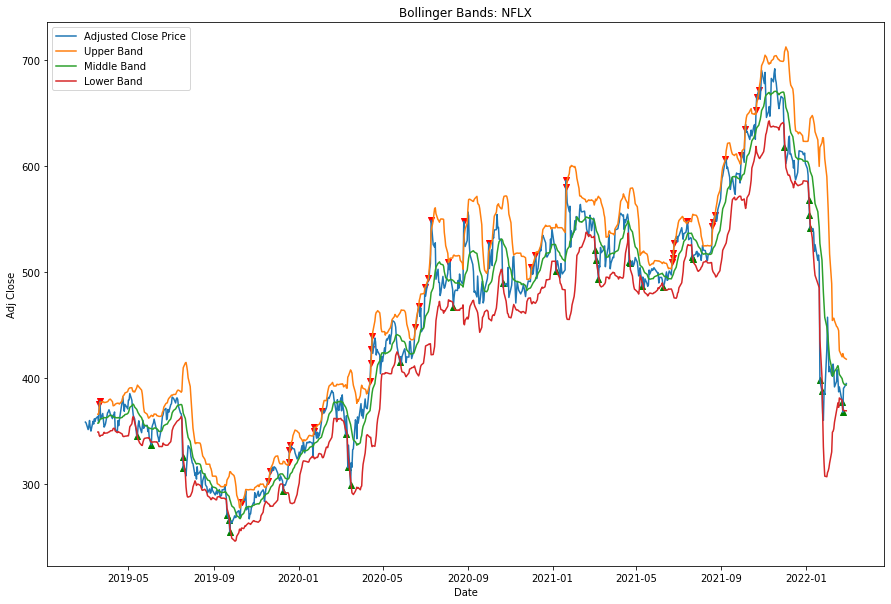

In [14]:
my_assets = 'NFLX'
start_date = '2019-03-01'
end_date = '2022-03-01'
data = read_data(my_assets, start_date, end_date)


bollinger_period = 13
rsi_period = 14

RSI_Bollinger_Band(data, bollinger_period, rsi_period, my_assets)